# 目的
- 正味重量分布を推定する
- 独立に推定するのではなく、種類を合わせてモデルを立てる

In [2]:
import os, sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

import ChocoUtils as cu

In [7]:
sns.set()

## データの取得と確認

In [9]:
data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="taste in (0, 1, 4, 11, 12)")
grp = data.groupby(['taste'])
print(grp.count()[['net_weight']])

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE taste in (0, 1, 4, 11, 12);
Shape of MeasurementData(record_num, n_columns) : (424, 14)
       net_weight
taste            
0             344
1              34
4              10
11             16
12             20


In [5]:
# 仕様の重量
spec = {0:28.0, 1:25.0, 4:22.0, 7:26.0, 10:22.0, 11:22.0, 12:22.0}
taste_name = {0:"peanut", 1:"strawberry", 4:"ama-zake", 
              7:"pachi-pachi", 10:"pineapple", 
              11:"milk-caramel", 12:"choco-banana"}


/home/yoichi/.pyenv/versions/anaconda2-4.3.0/envs/choco3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


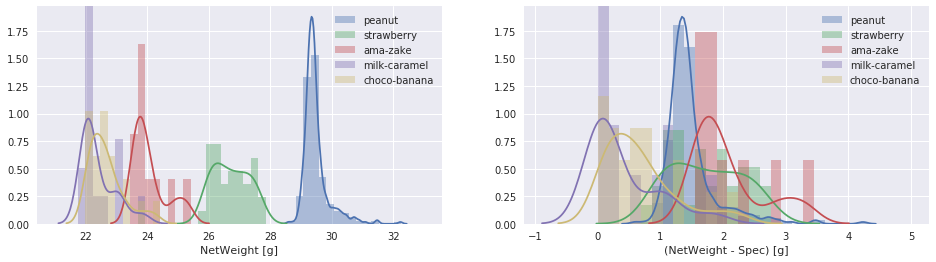

In [11]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins = np.linspace(0, 5.0, 30)
for key, value in grp:
    sns.distplot(value["net_weight"], bins=np.linspace(21, 33, 50), hist=True, label=taste_name[key], ax=ax[0])
    sns.distplot((value["net_weight"] - spec[key]), bins=bins, hist=True, label=taste_name[key], ax=ax[1])
ax[0].set_xlabel("NetWeight [g]")
ax[1].set_xlabel("(NetWeight - Spec) [g]")
ax[0].legend()
ax[1].legend()
fig.savefig("weight_histogram.png")

## 重量パラメータの推定
- 重量は正規分布に従うと仮定 ←この仮定はあとで見直し
- 独立にパラメータを予測した場合と、階層モデルで予測した場合を比較する

In [42]:
taste = data['taste'].values
taste_idx = pd.Categorical(data['taste']).codes
spec_lst = np.array([spec[i] for i in set(taste)])
print(spec_lst)
print(set(taste))
print(set(taste_idx))

[28. 25. 22. 22. 22.]
{0, 1, 4, 11, 12}
{0, 1, 2, 3, 4}


### 独立にパラメータを予測

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sds, alpha]
100%|██████████| 5500/5500 [00:09<00:00, 591.36it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80bf1607b8>,
      dtype=object)

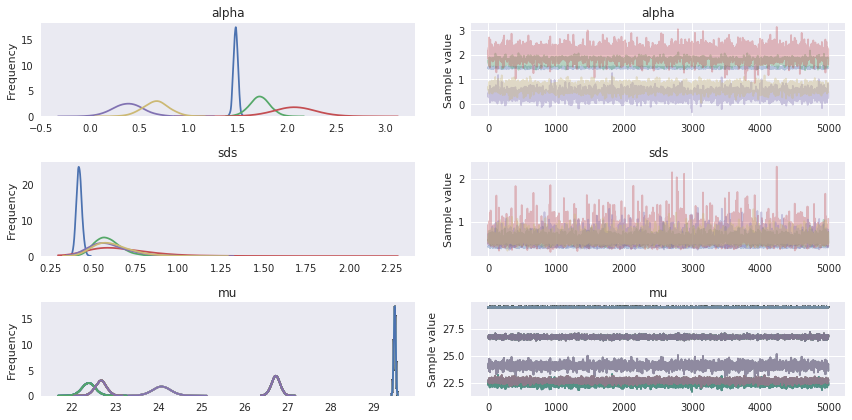

In [43]:
with pm.Model() as comparing_weight:
    alpha = pm.Normal('alpha', mu=0, sd=10, shape=len(set(taste_idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(taste_idx)))
    mu = pm.Deterministic('mu', spec_lst[taste_idx]+alpha[taste_idx])
    
    weights = pm.Normal('weights', mu=mu, sd=sds[taste_idx], observed=data['net_weight'].values)
    
    trace = pm.sample(5000, chains=1)
pm.traceplot(trace)

### 階層モデルとして推定

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sds, alpha, asd, am]
100%|██████████| 5500/5500 [00:10<00:00, 538.59it/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80bd4dce80>,
      dtype=object)

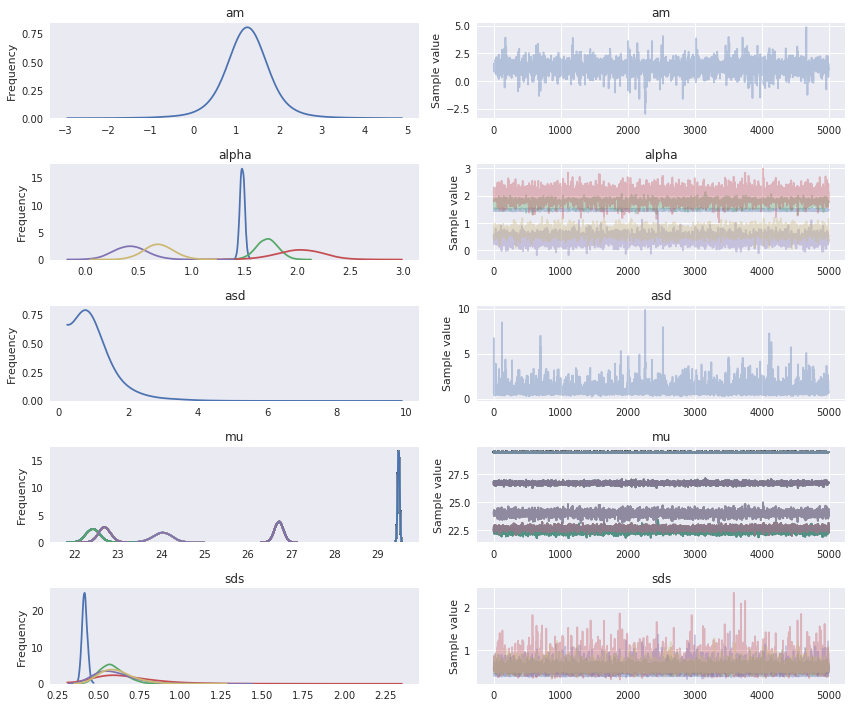

In [47]:
with pm.Model() as comparing_weight_h:
    # 階層事前分布
    am = pm.Normal('am', mu=0, sd=10)
    asd = pm.HalfNormal('asd', sd=10)
    # 事前分布
    alpha = pm.Normal('alpha', mu=am, sd=asd, shape=len(set(taste_idx)))
    mu = pm.Deterministic('mu', spec_lst[taste_idx]+alpha[taste_idx])
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(taste_idx)))
    # 重量モデル
    weights = pm.Normal('weights', mu=mu, sd=sds[taste_idx], observed=data['net_weight'].values)
    
    trace = pm.sample(5000, chains=1)
pm.traceplot(trace)